# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Save model and resources](#Save-model-and-resources)
    * [Training stats](#Training-stats)
* [Test model](#Test-model)
    * [Predict with training model](#Predict-with-training-model)
    * [Predict with serving model](#Predict-with-serving-model)

In [1]:
# codecarbon - start tracking
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(log_level = "WARNING", save_to_api = True, experiment_id = "6d2c8401-afba-42de-9600-6e95bea5fd80")
tracker.start()

[codecarbon WARNING @ 15:19:09] No CPU tracking mode found. Falling back on CPU constant mode.


# Imports

In [1]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, layers
from tensorflow.keras.utils import plot_model

from lib.dataset import *
from lib.directories import init_cache_dir, init_model_dir
from lib.eval import top_predictions
from lib.io import load_training_model, load_serving_model, save_model_bundle
from lib.plot import plot_training_stat

/Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [3]:
import json
import networkx as nx

def json2graph(file):
    """
    Parameters
    ----------
    file : json file
        json file containing node and edges (parent nodes)
    """

    data = json.load(file)
    graph = nx.DiGraph()
    
    nodes = []
    for elem in data:
        nodes.append(elem)
    
    edges = []
    for elem in data:
        for parent in data[elem]['parents']:
            edge = (elem, parent)
            edges.append(edge)
    
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    return graph

f = open('../data/category_taxonomy.json')
G = json2graph(f)

In [4]:
G.out_edges(['en:wheat-flour-type-55-for-bread'])

OutEdgeDataView([('en:wheat-flour-type-55-for-bread', 'en:common-wheat-flours'), ('en:wheat-flour-type-55-for-bread', 'en:white-wheat-flours')])

In [21]:
list(G.predecessors('en:meals'))

['en:filled-fritter-garnished-with-shrimps-and-vegetables-and-poultry-and-meat',
 'en:crepes-filled-with-fish',
 'en:buckwheat-crepe-with-mushrooms',
 'en:cooked-unsalted-couscous',
 'en:egg-poached',
 'fr:fondues',
 'en:egg-fried-without-added-fat',
 'en:prepared-lentils',
 'en:samosas',
 'en:fresh-meals',
 'en:spanish-omelettes',
 'en:truffades',
 'en:focaccia',
 'en:pork-sausage-stew-with-cabbage-carrots-and-potatoes',
 'en:tajine',
 'en:vegetable-fritters',
 'en:meal-replacements',
 'en:waterzooi',
 'en:meals-with-meat',
 'en:refrigerated-meals',
 'en:aligots',
 'en:meals-with-fish',
 'en:puff-pastry-meals',
 'en:fajitas',
 'en:egg-white-cooked',
 'en:prepared-vegetables',
 'en:chinese-dumplings',
 'en:stuffed-vine-leaves',
 'fr:crepes-au-jambon',
 'en:egg-soft-boiled',
 'en:microwave-meals',
 'en:stuffed-cabbage',
 'en:filled-fritters',
 'en:buckwheat-crepe-filled-with-cheese-ham-and-mushrooms',
 'en:stews',
 'fr:poelees',
 'en:gratins',
 'en:prepared-salads',
 'en:crepes-filled-w

# Configuration

In [6]:
MODEL_BASE_DIR = pathlib.Path('../models')
CACHE_DIR = pathlib.Path('../tensorflow_cache')

PREPROC_BATCH_SIZE = 10_000  # some large value, only affects execution time

# splits are handled by `tfds.load`, see doc for more elaborate ways to sample
TRAIN_SPLIT = 'train[:80%]'
VAL_SPLIT = 'train[80%:90%]'
TEST_SPLIT = 'train[90%:]'

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `load_dataset('off_categories', ...)` to access the dataset.

In [7]:
import datasets.off_categories

builder = tfds.builder('off_categories')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_categories

# Build model

In [8]:
tf.random.set_seed(42)

## Model inputs

In [9]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [10]:
ds = load_dataset('off_categories', split=TRAIN_SPLIT)

In [11]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = 93_000,
    output_sequence_length = 30)

product_name_vectorizer.adapt(
    select_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = 64,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = 64,
    recurrent_dropout = 0.2,
    dropout = 0.0))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

len(product_name_vectorizer.get_vocabulary())

CPU times: user 43.2 s, sys: 33.5 s, total: 1min 16s
Wall time: 9.86 s


93000

In [12]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    flat_batch(select_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 3,
    max_tokens = 5_000)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

len(ingredients_vocab)

CPU times: user 52 s, sys: 32 s, total: 1min 23s
Wall time: 9.99 s


5000

## Model output

In [5]:
categories_vocab_nodes=list(G.nodes)

In [20]:
%%time

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    flat_batch(select_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 10)

# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab_nodes,
    output_mode = 'multi_hot',
    num_oov_indices = 1)

def categories_encode(ds: tf.data.Dataset):
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        return (x, y)

    # applies to non-batched dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .apply(filter_empty_labels)
    )

len(categories_vocab)

CPU times: user 49.4 s, sys: 37 s, total: 1min 26s
Wall time: 9.97 s


5205

## Model

In [15]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.2)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab_nodes), activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs[k] for k in features], outputs=[output])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_name (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 30)           0           product_name[0][0]               
__________________________________________________________________________________________________
ingredients_tags (InputLayer)   [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       5952000     text_vectorization[0][0]         
______________________________________________________________________________________________

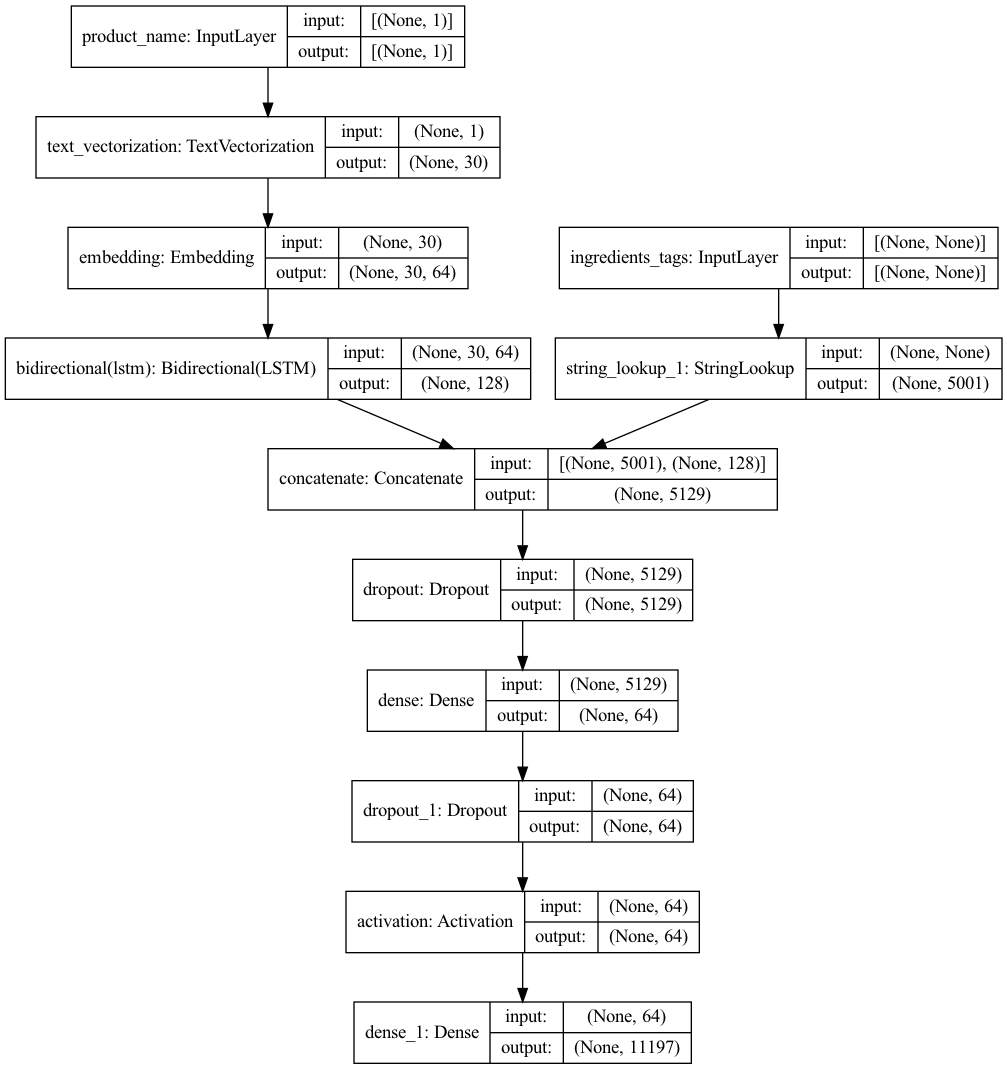

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train model

In [18]:
# Remember to clean obsolete dirs once in a while
#MODEL_DIR = init_model_dir(MODEL_BASE_DIR)
MODEL_DIR = pathlib.Path("../models/Models.20220531-203603")
CACHE_DIR = init_cache_dir(CACHE_DIR)

batch_size = 128

Cache directory: ../tensorflow_cache


In [19]:
%%time

ds_train = (
    load_dataset('off_categories', split=TRAIN_SPLIT, features=features, as_supervised=True)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    load_dataset('off_categories', split=VAL_SPLIT, features=features, as_supervised=True)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'val'))
)

history = model.fit(
    ds_train,
    epochs = 50,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(MODEL_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        callbacks.EarlyStopping(monitor='val_loss', patience=4),
        callbacks.CSVLogger(str(MODEL_DIR / 'training.log')),
        callbacks.History()
    ]
)

Epoch 1/50


ValueError: in user code:

    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/hui-guan/opt/miniconda3/envs/off/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 11197) vs (None, 5205))


## Save model and resources

In [16]:
save_model_bundle(MODEL_DIR, model, categories_vocab_nodes)

INFO:tensorflow:Assets written to: ../model.20220527-132349/training_model/assets


INFO:tensorflow:Assets written to: ../model.20220527-132349/training_model/assets


INFO:tensorflow:Assets written to: ../model.20220527-132349/serving_model/assets


INFO:tensorflow:Assets written to: ../model.20220527-132349/serving_model/assets


## Training stats

In [29]:
stats = pd.read_csv(MODEL_DIR / 'training.log')
stats

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.999241,0.005047,0.018141,0.012443,0.999583,0.001917,0.795805,0.056038
1,1,0.999602,0.001632,0.768470,0.212784,0.999698,0.001180,0.871820,0.358295
2,2,0.999714,0.001078,0.820906,0.452573,0.999771,0.000826,0.881524,0.550441
3,3,0.999794,0.000835,0.839754,0.576481,0.999805,0.000691,0.880624,0.638971
4,4,0.999812,0.000726,0.849622,0.634293,0.999819,0.000633,0.882040,0.675028
5,5,0.999819,0.000667,0.855833,0.664896,0.999828,0.000600,0.882970,0.696709
6,6,0.999827,0.000628,0.860431,0.685760,0.999834,0.000579,0.883375,0.712532
7,7,0.999833,0.000599,0.863929,0.701138,0.999837,0.000567,0.885170,0.721499
8,8,0.999836,0.000576,0.866893,0.713686,0.999842,0.000555,0.884748,0.732175
9,9,0.999839,0.000557,0.869332,0.723618,0.999844,0.000549,0.884604,0.737222


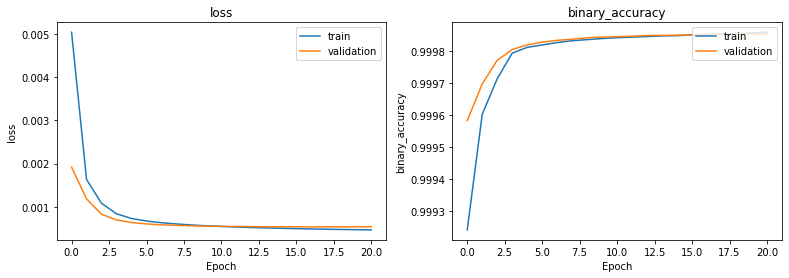

In [30]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

plot_training_stat(stats, 'loss', ax1)
plot_training_stat(stats, 'binary_accuracy', ax2)

# Test model

In [31]:
training_model = load_training_model(MODEL_DIR)
serving_model = load_serving_model(MODEL_DIR)

TypeError: ('Keyword argument not understood:', 'sparse')

In [27]:
ds_test = load_dataset('off_categories', split=TEST_SPLIT)

## Predict with training model

In [21]:
%%time

training_pred_test = training_model.predict(ds_test.padded_batch(128))

print(training_pred_test.shape)
training_pred_test

/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['categories_tags', 'code'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


(85760, 5205)
CPU times: user 36.6 s, sys: 8.16 s, total: 44.8 s
Wall time: 9.09 s


array([[9.2338169e-01, 9.1812074e-01, 1.1689961e-03, ..., 2.3601480e-08,
        2.7538024e-07, 3.2840742e-08],
       [8.8147974e-01, 8.7351203e-01, 2.8353930e-04, ..., 7.5147000e-11,
        3.8100993e-09, 6.3007155e-07],
       [9.7078896e-01, 9.7021067e-01, 1.7446170e-07, ..., 6.8437152e-14,
        1.2844977e-12, 3.3839781e-10],
       ...,
       [2.1886206e-01, 2.0773542e-01, 1.7316398e-01, ..., 6.1721825e-05,
        7.0206559e-05, 6.2197316e-05],
       [4.1987896e-03, 7.6553226e-04, 6.0066777e-05, ..., 5.4362738e-12,
        3.2658498e-10, 2.5570373e-06],
       [2.3281223e-06, 2.7602388e-07, 9.1620833e-01, ..., 2.8868532e-08,
        4.4399904e-11, 1.9896805e-13]], dtype=float32)

## Predict with serving model

In [22]:
%%time

serving_pred_test = serving_model.predict(ds_test.padded_batch(128))

serving_pred_test

CPU times: user 1min 2s, sys: 3.75 s, total: 1min 6s
Wall time: 14.5 s


(array([[9.4916189e-01, 9.3427873e-01, 9.2934412e-01, ..., 4.4587255e-04,
         4.3931603e-04, 3.9973855e-04],
        [9.1675323e-01, 8.8377762e-01, 8.8147974e-01, ..., 1.9071102e-03,
         1.8906593e-03, 1.8838942e-03],
        [9.7430325e-01, 9.7078896e-01, 9.7021067e-01, ..., 1.8456578e-04,
         1.8221140e-04, 1.8087029e-04],
        ...,
        [2.3283073e-01, 2.1886206e-01, 2.0773542e-01, ..., 1.2994498e-02,
         1.2585163e-02, 1.1807442e-02],
        [9.5606601e-01, 9.4531786e-01, 9.4348717e-01, ..., 8.0126524e-04,
         7.9897046e-04, 7.6553226e-04],
        [9.6999109e-01, 9.1928327e-01, 9.1620833e-01, ..., 3.8003922e-04,
         3.4916401e-04, 3.4716725e-04]], dtype=float32),
 array([[b'en:spreads', b'en:fruit-and-vegetable-preserves',
         b'en:plant-based-spreads', ..., b'en:blackberry-jellies',
         b'en:sweet-snacks', b'en:confectioneries'],
        [b'en:fruits-and-vegetables-based-foods', b'en:compotes',
         b'en:plant-based-foods-and-bev

In [23]:
%%time

top_predictions(ds_test, serving_pred_test, 4)

CPU times: user 22.4 s, sys: 3.48 s, total: 25.8 s
Wall time: 16 s


,code,product_name,0,1,2,3
0,0637793029422,Blueberry preserve,en:spreads: 94.92%,en:fruit-and-vegetable-preserves: 93.43%,en:plant-based-spreads: 92.93%,en:sweet-spreads: 92.6%
1,5400141381191,Mousseline de pommes,en:fruits-and-vegetables-based-foods: 91.68%,en:compotes: 88.38%,en:plant-based-foods-and-beverages: 88.15%,en:plant-based-foods: 87.35%
2,3250392084080,Choux-Fleurs Bio,en:fruits-and-vegetables-based-foods: 97.43%,en:plant-based-foods-and-beverages: 97.08%,en:plant-based-foods: 97.02%,en:vegetables-based-foods: 96.71%
3,8425275510085,Aceite de oliva virgen extra,en:fats: 99.91%,en:plant-based-foods-and-beverages: 99.9%,en:plant-based-foods: 99.89%,en:vegetable-oils: 99.83%
4,4260193516047,Yörem Ayran,en:beverages: 93.01%,en:fermented-foods: 78.44%,en:fermented-milk-products: 76.72%,en:dairies: 71.37%
...,...,...,...,...,...,...
85755,8410500021757,Oikos tentaciones tarta de arándanos,en:fermented-foods: 96.5%,en:dairies: 95.54%,en:fermented-milk-products: 94.57%,en:yogurts: 91.17%
85756,0810176020524,Beef jerky,en:snacks: 65.96%,en:beef-jerkies: 55.97%,en:meats: 55.51%,en:dried-meats: 46.86%
85757,4820003487471,ідеаль немолоко вівсяне,en:beverages: 23.28%,en:plant-based-foods-and-beverages: 21.89%,en:plant-based-foods: 20.77%,en:snacks: 17.32%
85758,7613269520931,Mozzarella,en:dairies: 95.61%,en:fermented-foods: 94.53%,en:fermented-milk-products: 94.35%,en:cheeses: 94.26%


In [2]:
# codecarbon - stop tracking
tracker.stop()

2.8354071001211803e-06